In [10]:
import math
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.callbacks import Callback
from matplotlib import pyplot as plt

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


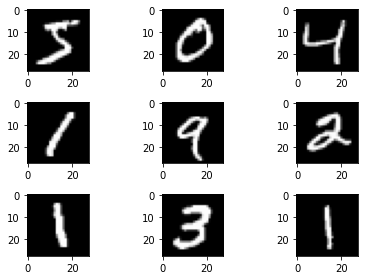

In [11]:
# Some functions below have been taken from https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

(trainX, trainY), (testX, testY) = mnist.load_data()
# Summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))
# Plot first few images
for i in range(9):
	# Define subplot
	ax = plt.subplot(3,3,i+1)
	# plot raw pixel data
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.tight_layout()
plt.show()

In [12]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

In [4]:
# Reshape dataset for the first (baseline) neural network
trainX_base = trainX.copy().reshape(trainX.shape[0],-1)
testX_base = testX.copy().reshape(testX.shape[0],-1)
# Categorize training but not testing set
trainY_base = to_categorical(trainY)
testY_base = testY.copy()

In [6]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [8]:
# The first NN with softmax regression and no hidden layers
def softmax(z):
    '''
    Preconditions:
    [z] is a vector.
    '''
    return np.exp(z)/np.sum(np.exp(z),axis=0)

def l(y,y_hat):
    return -1*np.sum(y*np.log(y_hat))

# My implementation of a softmax-regression NN (slow)
def basic_softmax_NN(trainX,trainY):
    '''
    Preconditions:
    [trainX] is a 2D-array, where the first dimension is number of training examples, and the second dimension is # of input nodes.
    '''
    alpha = 0.01

    # Number of examples
    m = trainX.shape[0]
    # Reshape training data
    X = trainX.T
    Y = trainY.T
    # Initialize weights
    W = np.random.rand(10,X.shape[0])/1000
    b = np.random.rand(10,1)
    for step in range(100):
        if np.isnan(W[0,0]):
            raise ValueError
        if step % 10 == 0:
            print("Step %i." % step)
        Z = W @ X + b
        Y_hat = softmax(Z)
        db = 1/m*np.sum(Y_hat - Y,axis=1,keepdims=True)
        dW = 1/m*(Y_hat-Y) @ X.T
        W = W - alpha*dW
        b = b - alpha*db
    return W,b

# A faster way that does something similar to a mini-batch optimization: weights are corrected and updated for every sample.
# Technically, not the way NNs are usually implemented but works MUCH faster and has roughly the same accuracy.
def basic_softmax_NN_custom(trainX,trainY):
    '''
    Preconditions:
    [trainX] is a 2D-array, where the first dimension is number of training examples, and the second dimension is # of input nodes.
    '''
    alpha = 0.01
    history = []

    # Divide by 1,000 to prevent divergence
    W = np.random.rand(10,trainX.shape[1])/1000
    b = np.random.rand(10,1)
    for n in range(trainX.shape[0]):
        if math.isnan(W[0,0]):
            return W,b
        # Forward propagation
        x = trainX[n].reshape(-1,1)
        y = trainY[n].reshape(-1,1)
        z = W @ x + b
        y_hat = softmax(z)
        history.append(l(y,y_hat))
        # Backpropagation 
        db = y_hat - y
        for i in range(W.shape[0]):
            dWi = db[i]*x
            # Divide by 1,000 to prevent divergence
            W[i] = W[i] - alpha*dWi.reshape(-1,)/1000
        b = b - alpha*db
    return W,b, history

def predict_1(x,W,b):
    z = W @ x + b.reshape(-1,)
    max_ind = np.argmax(softmax(z))
    return max_ind

def test_accuracy(testX,testY,W,b):
    '''Preconditions: [testY] is not categorized.'''    
    res = np.zeros(testY.shape)
    for i in range(res.size):
        y_hat = predict_1(testX[i],W,b)
        if y_hat == testY[i]:
            res[i] = True
        else:
            res[i] = False
    print("Accuracy: %s %%." % (100*np.count_nonzero(res)/res.size))
    return res

In [9]:
# Our "custom" NN gives better results than the first implementation
W,b,history = basic_softmax_NN_custom(trainX_base,trainY_base)
_ = test_accuracy(testX_base, testY_base,W,b)

Accuracy: 87.07 %.


In [12]:
# However, normalizing pixel values negatively affects accuracy of our NN
trainX_norm, testX_norm = prep_pixels(trainX_base, testX_base)
W_norm,b_norm,_ = basic_softmax_NN_custom(trainX_norm,trainY_base)
_ = test_accuracy(testX_norm, testY_base,W_norm,b_norm)

Accuracy: 74.79 %.


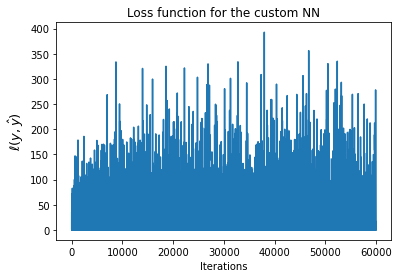

In [13]:
plt.plot(history)
plt.xlabel("Iterations")
plt.ylabel("$\ell(y,\hat{y})$",size=13)
plt.title("Loss function for the custom NN")
plt.show()

In [14]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

trainX, trainY, testX, testY = load_dataset()

# Tweak epochs to see the accuracy change
model = define_model()
history = model.fit(trainX, trainY,
          batch_size=512,
          epochs=5,
          verbose=1,
          validation_data=(testX, testY),)
score = model.evaluate(testX, testY, verbose=0)

Epoch 1/5
118/118 [==============================] - 7s 57ms/step - loss: 962.0462 - accuracy: 0.7125 - val_loss: 0.3033 - val_accuracy: 0.9099
Epoch 2/5
118/118 [==============================] - 7s 62ms/step - loss: 0.2469 - accuracy: 0.9266 - val_loss: 0.2189 - val_accuracy: 0.9364
Epoch 3/5
118/118 [==============================] - 8s 65ms/step - loss: 0.1654 - accuracy: 0.9492 - val_loss: 0.1851 - val_accuracy: 0.9462
Epoch 4/5
118/118 [==============================] - 9s 76ms/step - loss: 0.1295 - accuracy: 0.9605 - val_loss: 0.1891 - val_accuracy: 0.9444
Epoch 5/5
118/118 [==============================] - 9s 74ms/step - loss: 0.1014 - accuracy: 0.9699 - val_loss: 0.1946 - val_accuracy: 0.9446


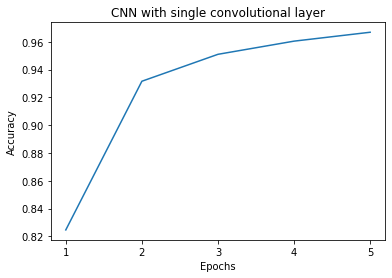

In [15]:
plt.plot([1,2,3,4,5],history.history['accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks([1,2,3,4,5])
plt.title("CNN with single convolutional layer")
plt.show()

In [16]:
history.history['accuracy']

[0.82464998960495,
 0.9315666556358337,
 0.9509333372116089,
 0.9603999853134155,
 0.9667999744415283]

In [18]:
score

[0.19462484121322632, 0.944599986076355]

In [19]:
# Add a max pooling layer
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
	model.add(Flatten())
	model.add(Dense(10, activation='softmax'))
    # compile model
	opt = SGD(lr=0.01)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

trainX, trainY, testX, testY = load_dataset()

# Tweak epochs to see the accuracy change
model = define_model()
history = model.fit(trainX, trainY,
          batch_size=512,
          epochs=5,
          verbose=1,
          validation_data=(testX, testY),)
score = model.evaluate(testX, testY, verbose=0)


Epoch 1/5
118/118 [==============================] - 10s 85ms/step - loss: 794.1453 - accuracy: 0.6666 - val_loss: 0.4047 - val_accuracy: 0.8812
Epoch 2/5
118/118 [==============================] - 10s 87ms/step - loss: 0.3466 - accuracy: 0.9010 - val_loss: 0.3026 - val_accuracy: 0.9100
Epoch 3/5
118/118 [==============================] - 10s 81ms/step - loss: 0.2763 - accuracy: 0.9196 - val_loss: 0.2840 - val_accuracy: 0.9163
Epoch 4/5
118/118 [==============================] - 11s 91ms/step - loss: 0.2460 - accuracy: 0.9274 - val_loss: 0.2455 - val_accuracy: 0.9237
Epoch 5/5
118/118 [==============================] - 10s 82ms/step - loss: 0.2187 - accuracy: 0.9338 - val_loss: 0.2707 - val_accuracy: 0.9156


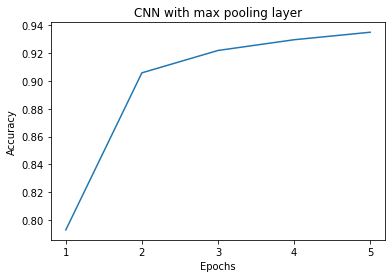

In [20]:
plt.plot([1,2,3,4,5],history.history['accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks([1,2,3,4,5])
plt.title("CNN with max pooling layer")
plt.show()

In [21]:
history.history['accuracy']

[0.7930166721343994,
 0.9057499766349792,
 0.9218000173568726,
 0.9294999837875366,
 0.9348833560943604]

In [22]:
score

[0.27071815729141235, 0.9156000018119812]

In [13]:
# Add a max pooling layer
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
	model.add(Conv2D(64, (5, 5), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Flatten())
	model.add(Dense(1000, activation='relu'))
	model.add(Dense(10, activation='softmax'))
    # compile model
	opt = SGD(lr=0.01)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

trainX, trainY, testX, testY = load_dataset()

# Tweak epochs to see the accuracy change
model = define_model()
history = model.fit(trainX, trainY,
          batch_size=512,
          epochs=10,
          verbose=1,
          validation_data=(testX, testY),)
score = model.evaluate(testX, testY, verbose=0)


Epoch 1/10
118/118 [==============================] - 25s 211ms/step - loss: 54066.7754 - accuracy: 0.1116 - val_loss: 2.3022 - val_accuracy: 0.1135
Epoch 2/10
118/118 [==============================] - 27s 226ms/step - loss: 2.3022 - accuracy: 0.1119 - val_loss: 2.3020 - val_accuracy: 0.1135
Epoch 3/10
118/118 [==============================] - 26s 223ms/step - loss: 2.3021 - accuracy: 0.1101 - val_loss: 2.3018 - val_accuracy: 0.1135
Epoch 4/10
118/118 [==============================] - 23s 198ms/step - loss: 2.3017 - accuracy: 0.1133 - val_loss: 2.3016 - val_accuracy: 0.1135
Epoch 5/10
118/118 [==============================] - 22s 190ms/step - loss: 2.3017 - accuracy: 0.1142 - val_loss: 2.3015 - val_accuracy: 0.1135
Epoch 6/10
118/118 [==============================] - 25s 215ms/step - loss: 2.3015 - accuracy: 0.1121 - val_loss: 2.3014 - val_accuracy: 0.1135
Epoch 7/10
118/118 [==============================] - 26s 217ms/step - loss: 2.3016 - accuracy: 0.1110 - val_loss: 2.3013 - va

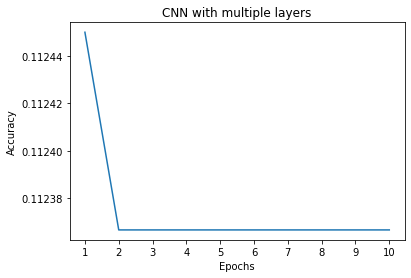

In [14]:
plt.plot([1,2,3,4,5,6,7,8,9,10],history.history['accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.title("CNN with multiple layers")
plt.show()

In [15]:
history.history['accuracy']

[0.1124500036239624,
 0.11236666887998581,
 0.11236666887998581,
 0.11236666887998581,
 0.11236666887998581,
 0.11236666887998581,
 0.11236666887998581,
 0.11236666887998581,
 0.11236666887998581,
 0.11236666887998581]

In [16]:
score

[2.301162004470825, 0.11349999904632568]